In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from workflow import TradeEnv, train_A2C, trade

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv("prices_and_features.csv", index_col=0, parse_dates=True)

df.head(3)

,AAPL,DIS,JPM,AAPL_M,DIS_M,JPM_M,AAPL_H,DIS_H,JPM_H,AAPL_R,DIS_R,JPM_R,AAPL_C,DIS_C,JPM_C,AAPL_X,DIS_X,JPM_X,TURB
Date,,,,,,,,,,,,,,,,,,,
2009-03-17,3.017134,15.344792,17.415800,0.028964,-0.496127,-0.220801,0.034247,0.259793,0.561729,62.816630,53.582561,58.959516,136.322306,71.048919,96.572930,73.974536,55.254589,62.899241,0.653865
2009-03-18,3.073445,15.594510,18.780525,0.047260,-0.385191,0.094233,0.042034,0.296583,0.701410,68.653609,60.064399,60.315013,163.097253,106.417535,130.380095,72.994244,50.816621,59.225709,2.282002
2009-03-19,3.076473,15.241461,17.284174,0.061297,-0.322049,0.220614,0.044857,0.287780,0.662233,68.634656,57.120986,54.852097,137.339404,87.350880,103.148275,72.187684,45.995264,55.465220,0.990593


In [3]:
trading_days = 252
years = 4
train_idx = trading_days * years

train_df = df.iloc[:train_idx]
test_df = df.loc[df.index[~df.index.isin(train_df.index)]]

train_df.shape, test_df.shape

((1008, 19), (2685, 19))

In [4]:
balance = 1_000
n_eps = 10

init_env = TradeEnv(train_df, n_stocks=3, balance=balance)
a2c = train_A2C(init_env, n_eps, progress_bar=True)

Output()

In [5]:
retrain_period = 126
n_splits = len(test_df) // retrain_period
tss = TimeSeriesSplit(n_splits=n_splits)
growing_train_df = train_df
preds = []

for i, (train_idx, test_idx) in enumerate(tss.split(test_df)):

    if i == 0:
        
        temp_test_df = test_df.iloc[train_idx]
        temp_test_env = TradeEnv(temp_test_df, n_stocks=3, balance=balance)

        equity, balance, preds = trade(temp_test_env, a2c, preds, progress=True)

        temp_train_df = temp_test_df
        growing_train_df = pd.concat([growing_train_df, temp_train_df])
        temp_test_df = test_df.iloc[test_idx]
        
        temp_train_env = TradeEnv(growing_train_df, n_stocks=3, balance=balance)
        temp_test_env = TradeEnv(temp_test_df, n_stocks=3, balance=balance)

        a2c = train_A2C(temp_train_env, n_eps=10)
        equity, balance, preds = trade(temp_test_env, a2c, preds, progress=True)
    
    else:

        temp_train_df = test_df.iloc[train_idx]
        growing_train_df = pd.concat([growing_train_df, temp_train_df])
        temp_test_df = test_df.iloc[test_idx]

        temp_train_env = TradeEnv(growing_train_df, n_stocks=3, balance=balance)
        temp_test_env = TradeEnv(temp_test_df, n_stocks=3, balance=balance)

        a2c = train_A2C(temp_train_env, n_eps=10)
        equity, balance, preds = trade(temp_test_env, a2c, preds, progress=True)

preds = pd.concat(preds)

2013-09-11 balance: $1,049.77
2014-03-07 balance: $1,067.00
2014-08-29 balance: $1,454.34
2015-02-25 balance: $1,638.72
2015-08-19 balance: $1,765.76
2016-02-12 balance: $1,612.30
2016-08-08 balance: $1,743.39
2017-02-01 balance: $2,017.39
2017-07-27 balance: $2,378.45
2018-01-22 balance: $2,754.21
2018-07-17 balance: $2,880.61
2019-01-10 balance: $2,952.38
2019-07-08 balance: $3,711.38
2019-12-30 balance: $5,036.95
2020-06-24 balance: $3,413.21
2020-12-16 balance: $4,543.44


[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

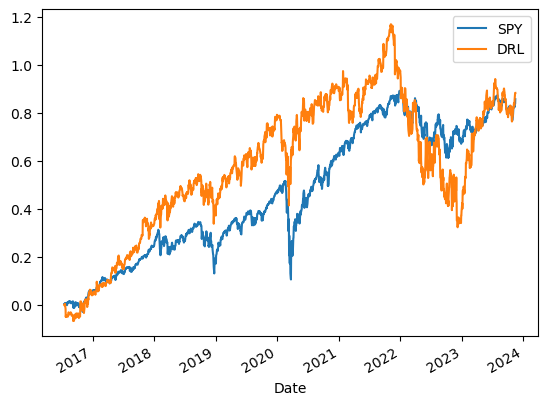

In [ ]:
import yfinance as yf

spy_prices = yf.download("SPY", preds.index.min(), preds.index.max()+pd.DateOffset(days=1))["Adj Close"]

backtest = pd.concat([spy_prices, preds], axis=1)
backtest.columns = ["SPY", "DRL"]

backtest_rets = np.log(backtest).diff().dropna()
backtest_rets.cumsum().plot()

In [ ]:
from portfolio_stats import PortfolioStats

stats = PortfolioStats(backtest_rets, log=True)
stats.info

,SHARPE,CUMU_RET,ANN_RET,ANN_VOL,MAX_DD
SPY,0.624257,0.858551,0.117202,0.187747,-0.411241
DRL,0.394354,0.884792,0.120784,0.306284,-0.847295
